In [33]:
from os.path import join, dirname, abspath
import yaml

import matplotlib.pyplot as plt

from pypsa import Network

from postprocessing.utils import *

### Parameters

In [41]:
year = 2018

techs = ["ccgt", "pv_residential_national", "pv_utility_national",
         "wind_offshore_national", "wind_onshore_national",
         "AC", "DC", "Li-ion"]
techs_generic = ["ccgt", "pv_residential", "pv_utility",
                 "wind_offshore", "wind_onshore",
                 "AC", "DC", "Li-ion"]

regions_dict = {'Iberia': ['ES', 'PT'],
                'Central West': ['NL', 'BE', 'LU', 'FR', 'DE'],
                'Nordics': ['DK', 'NO', 'SE', 'FI'],
                'British Isles': ['GB', 'IE'],
                'Central South': ['CH', 'IT', 'AT', 'SI'],
                'East': ['PL', 'HU', 'CZ', 'SK', 'LV', 'LT', 'EE'],
                'South': ['HR', 'GR', 'BG', 'RO']}

# cases = ["20200930_143715", "20201001_093322", "20201001_095114", "20201001_100241", "20201001_103012"]
cases = ['nositing_CWE_1.0', 'siting_CWE_1.0_hour_1.0', 'siting_CWE_1.0_day_1.0', 'siting_CWE_1.0_week_1.0']#, 'siting_CWE_0.5_week_1.0']
cases_short = ["nositing", "hour", "day", "week"]

### Loading solved nets

In [42]:
nets = dict.fromkeys(cases_short)
configs = dict.fromkeys(cases_short)
for i, case in enumerate(cases_short):
    output_dir = f'../../output/paper/{cases[i]}/'
    #output_dir = f'../../../output/sizing/tyndp2018/{case}/'
    net = Network()
    net.import_from_csv_folder(output_dir)
    nets[case] = net
    configs[case] = yaml.load(open(f"{output_dir}config.yaml", 'r'), Loader=yaml.FullLoader)

INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units


### Costs

In [43]:
# Costs of generators
techs = ["ccgt", "load", "pv_residential_national", "pv_utility_national", "ror",
         "wind_onshore_national", "wind_offshore_national"]
costs_1 = pd.DataFrame(index=techs, columns=cases_short)
for case in cases_short:
    net = nets[case]
    for tech in techs:
        costs_1.loc[tech, case] = net.generators[net.generators.type == tech].capital_cost.unique()[0]
print(costs_1)
        
costs_all = pd.DataFrame(index=["Generation", "Transmission", "Storage"], columns=cases_short)
for case in cases_short:
    net = nets[case]
    cost = get_generators_cost(net).sum() + get_links_capex(net).sum() + get_storage_cost(net).sum()
    costs_all.loc["Generation", case] = get_generators_cost(net).sum()
    costs_all.loc["Transmission", case] = get_links_capex(net).sum()
    costs_all.loc["Storage", case] = get_storage_cost(net).sum()
costs_all.loc["Total"] = costs_all.sum().round(3)
print(costs_all)

# Generation cost
techs = ["ccgt", "load", "pv_residential_national", "pv_utility_national", "ror",
         "wind_onshore_national", "wind_offshore_national"]
costs = pd.DataFrame(index=techs, columns=cases_short)
for case in cases_short:
    net = nets[case]
    costs[case] = get_generators_cost(net).round(3)
# print(costs)

                        nositing     hour      day     week
ccgt                          61       61       61       61
load                           0        0        0        0
pv_residential_national     36.5     36.5     36.5     36.5
pv_utility_national         24.1     24.1     24.1     24.1
ror                          NaN      NaN      NaN      NaN
wind_onshore_national       64.6     64.6     64.6     64.6
wind_offshore_national   89.5333  89.5333  89.5333  89.5333
             nositing     hour      day     week
Generation     61.253  61.1941  61.2531  61.2531
Transmission     0.25     0.37     0.25     0.25
Storage       1.25392  1.26291  1.25392  1.25392
Total          62.757   62.827   62.757   62.757


### Number of points

In [44]:
# Check number of sites per tech
nbs_df = pd.DataFrame(columns=cases_short, index=["Wind onshore", "Wind offshore", "PV utility", "PV residential", "RES"])
for case in cases_short:
    net = nets[case]
    nbs_df.loc["Wind onshore", case] = len(net.generators[net.generators.type == 'wind_onshore_national'])
    nbs_df.loc["Wind offshore", case] = len(net.generators[net.generators.type == 'wind_offshore_national'])
    nbs_df.loc["PV utility", case] = len(net.generators[net.generators.type == 'pv_utility_national'])
    nbs_df.loc["PV residential", case] = len(net.generators[net.generators.type == 'pv_residential_national'])
    nbs_df.loc["RES", case] = nbs_df[case].sum()
print(nbs_df)

nbs_df_c = pd.DataFrame(columns=cases_short, index=["Wind onshore", "Wind offshore", "PV utility", "PV residential", "RES"])
min_cap = 1e-3
for case in cases_short:
    net = nets[case]
    nbs_df_c.loc["Wind onshore", case] = len(net.generators[(net.generators.type == 'wind_onshore_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["Wind offshore", case] = len(net.generators[(net.generators.type == 'wind_offshore_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["PV utility", case] = len(net.generators[(net.generators.type == 'pv_utility_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["PV residential", case] = len(net.generators[(net.generators.type == 'pv_residential_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["RES", case] = nbs_df_c[case].sum()
print(nbs_df_c)
print(nbs_df_c/nbs_df)

                nositing  hour  day  week
Wind onshore         120   120  117   118
Wind offshore         38    37   37    37
PV utility             1     1    1     1
PV residential       120    85  107    96
RES                  279   243  262   252
                nositing  hour  day  week
Wind onshore         110   110  110   110
Wind offshore         37    37   37    37
PV utility             1     1    1     1
PV residential        16    14   16    15
RES                  164   162  164   163
                nositing      hour       day      week
Wind onshore    0.916667  0.916667  0.940171  0.932203
Wind offshore   0.973684  1.000000  1.000000  1.000000
PV utility      1.000000  1.000000  1.000000  1.000000
PV residential  0.133333  0.164706  0.149533  0.156250
RES             0.587814  0.666667  0.625954  0.646825


In [72]:
# Cost increase vs number of points
a = (costs_all.loc["Total"]/costs_all.loc["Total", cases[0]] - 1)*100
print(a)
b = nbs_df.loc["RES"]
plt.scatter(a, b)
plt.xlabel("Optimality Gap (%)")
plt.ylabel("Number of sites")
plt.xlim([-0.05, 5])
plt.ylim([0, 2000])
plt.grid()

KeyError: 'nositing_1.0'

In [45]:
# Comparing site in siting runs vs no siting, looking at the concepts of true positive etc
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases_short[0]]
min_cap = 1e-3
nositing_res_gens = nositing_net.generators[(nositing_net.generators.type.isin(techs)) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
nositing_set = set(nositing_res_gens.index)
roc_table = pd.DataFrame(columns=cases_short[1:], index=["TP", "FP", "FN"])
for case in cases_short[1:]:
    net = nets[case]
    res_gens = net.generators[(net.generators.type.isin(techs))] # & (net.generators.p_nom_opt > min_cap)]
    # print(len(res_gens))
    siting_set = set(res_gens.index)
    # True positives are sites that were selected by the siting which were selected by the 1 stage
    common_set = nositing_set.intersection(siting_set)
    roc_table.loc["TP", case] = len(common_set)
    # False positives are sites that were selected by the siting but not by the 1 stage
    add_set = siting_set - nositing_set
    roc_table.loc["FP", case] = len(add_set)
    # False negatives are sites that were not selected by the siting and were selected by the 1 stage
    missing_set = nositing_set - siting_set
    roc_table.loc["FN", case] = len(missing_set)
print(roc_table)
prec_recall = pd.DataFrame(columns=["Precision", "Recall"], index=cases_short[1:])
# Percentage of locations in stage 1 that were selected (True Positive Rate)
prec_recall["Recall"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FN'])
# Percentage of selected location that were in stage 1 (1 - False Positive Rate)
prec_recall["Precision"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FP'])
print((prec_recall*100).round(2))

# fpr = [0] + sorted(list(1-precision)) + [1]
# tpr = [0] + sorted(list(recall)) + [1]
#fpr = list(1-precision)
#tpr = list(recall)
#plt.plot(fpr, tpr)
#plt.scatter(fpr, tpr)
#plt.plot([0, 1], [0, 1])
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")

0.6707818930041153
0.9939024390243902
0.6259541984732825
1.0
0.6507936507936508
1.0
    hour  day  week
TP   163  164   164
FP    80   98    88
FN     1    0     0
      Precision  Recall
hour      67.08   99.39
day       62.60  100.00
week      65.08  100.00


In [10]:
# Same per technology
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3
for tech in techs:
    print(tech)
    nositing_res_gens = nositing_net.generators[(nositing_net.generators.type == tech) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
    nositing_set = set(nositing_res_gens.index)
    roc_table = pd.DataFrame(columns=cases[1:], index=["TP", "FP", "FN"])
    prec_recall = pd.DataFrame(columns=cases[1:], index=["Recall", "Precision"], dtype=float)
    for case in cases[1:]:
        net = nets[case]
        res_gens = net.generators[(net.generators.type == tech)] # & (net.generators.p_nom_opt > min_cap)]
        siting_set = set(res_gens.index)
        # True positives are sites that were selected by the siting which were selected by the 1 stage
        common_set = nositing_set.intersection(siting_set)
        roc_table.loc["TP", case] = len(common_set)
        # False positives are sites that were selected by the siting but not by the 1 stage
        add_set = siting_set - nositing_set
        roc_table.loc["FP", case] = len(add_set)
        # False negatives are sites that were not selected by the siting and were selected by the 1 stage
        missing_set = nositing_set - siting_set
        roc_table.loc["FN", case] = len(missing_set)

    #print(roc_table)
    # Recall = Percentage of locations in stage 1 that were selected
    prec_recall.loc["Recall"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FN'])
    # Precision = Percentage of selected location that were in stage 1
    prec_recall.loc["Precision"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FP'])
    print(f"\n{(prec_recall*100).round(2)}\n")

wind_onshore_national

           siting_CWE_0.25_hour_1.0
Recall                       100.00
Precision                     90.77

wind_offshore_national

           siting_CWE_0.25_hour_1.0
Recall                       100.00
Precision                     99.28

pv_utility_national

           siting_CWE_0.25_hour_1.0
Recall                        100.0
Precision                     100.0

pv_residential_national

           siting_CWE_0.25_hour_1.0
Recall                        91.53
Precision                     13.25



### Load

In [ ]:
print(f"Total load: {net.loads_t.p.sum().sum()/1e3}")
for case in cases:
    net = nets[case]
    load_shed = net.generators[net.generators.type == "load"]
    print(net.generators_t.p[load_shed.index].sum().sum())

### Capacities

#### Total capacities

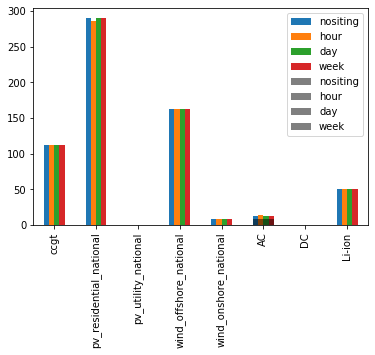

In [48]:
techs = ["ccgt", "pv_residential_national", "pv_utility_national",
         "wind_offshore_national", "wind_onshore_national",
         "AC", "DC", "Li-ion"]
capacities_df = pd.DataFrame(columns=cases_short, index=techs)
capacities_init_df = pd.DataFrame(columns=cases_short, index=techs)
for case in cases_short:
    net = nets[case]
    capacities = pd.concat([get_generators_capacity(net)["final"],
                            get_links_capacity(net)["new [TWkm]"] + get_links_capacity(net)["init [TWkm]"],
                            get_storage_energy_capacity(net)["new [GWh]"]])
    for tech in techs:
        capacities_df.loc[tech, case] = capacities[capacities.index.str.startswith(tech)].sum().round()
    # capacities_df[case] = capacities[techs].round().values
    capacities = pd.concat([get_generators_capacity(net)["init"],
                            get_links_capacity(net)["init [TWkm]"],
                            get_storage_power_capacity(net)["init [GW]"]])
    capacities_init_df[case] = capacities[techs].round().values
# capacities_df.round(3).to_csv("capacities.csv")
ax1 = capacities_df.plot(kind="bar")
capacities_init_df.plot(ax=ax1, kind="bar", color='k', alpha=0.5)
#plt.xticks(rotation="45")
plt.savefig(f"capacities_{year}.png", bbox_inches="tight")

### Generation

In [50]:
techs = ['wind_onshore_national', 'wind_offshore_national', 'pv_residential_national', 'pv_utility_national']

generation_df = pd.DataFrame(columns=cases_short, index=techs_generic)
ccgt_generation_df = pd.DataFrame(columns=cases_short, index=["Capacity (GW)", "Generation (TWh)"], dtype=float)
for case in cases_short:
    print(case)
    net = nets[case]
    res_gens = net.generators[net.generators.type.isin(techs)]
    total_cap = res_gens.p_nom_opt.sum()
    total_gen = (net.generators_t.p[res_gens.index]).sum().sum()
    print(f"Total capacity: {total_cap:.2f}")
    print(f"Total generation: {total_gen/1e3:.2f}")
    ccgt_gens = net.generators[net.generators.type == 'ccgt']
    ccgt_generation_df.loc["Capacity (GW)", case] = ccgt_gens.p_nom_opt.sum()
    ccgt_generation_df.loc["Generation (TWh)", case] = net.generators_t.p[ccgt_gens.index].sum().sum()/1e3
    print()
print(ccgt_generation_df.round(2))

nositing
Total capacity: 459.85
Total generation: 741.78

hour
Total capacity: 456.74
Total generation: 740.77

day
Total capacity: 459.85
Total generation: 741.78

week
Total capacity: 459.85
Total generation: 741.78

                  nositing    hour     day    week
Capacity (GW)       112.01  111.90  112.01  112.01
Generation (TWh)    371.72  372.62  371.72  371.72


### Potential

### Transmission

In [ ]:
# Capacity overall
capacities_df = pd.DataFrame(index=["AC", "DC"], columns=["init"] + cases)
for case in cases:
    net = nets[case]
    capacities = get_links_capacity(net)
    capacities_df["init"] = capacities["init [TWkm]"]
    capacities_df[case] = capacities["new [TWkm]"]
capacities_df.loc["Total"] = capacities_df.loc["AC"] + capacities_df.loc["DC"]
print(f"Added capacity:\n {capacities_df}")

# In Europe
"""
capacities_eu_df = pd.DataFrame(index=["AC", "DC"], columns=["init"] + cases)
outside_nodes = regions_dict["GLIS"] + regions_dict["NA"]
print(outside_nodes)
for case in cases:
    net = nets[case]
    capacities = get_links_capacity(net, outside_nodes)
    capacities_eu_df["init"] = capacities["init [TWkm]"]
    capacities_eu_df[case] = capacities["new [TWkm]"]
print(f"Added capacity:\n {capacities_eu_df}")
"""
0

In [ ]:
# Maps of flows
from postprocessing.plotly import SizingPlotly

for case in cases:
    net = nets[case]
    sp = SizingPlotly(net)
    #fig = sp.plot_topology()
    #fig = sp.plot_capacity("init")
    #fig.show()
    fig = sp.plot_capacity("final")
    fig.show()
    #fig.write_image(f"transmission_capacity_{case}.png", dpi=300)
    # fig.write_html(f"{case}_topology_heatmap.html", auto_open=True)

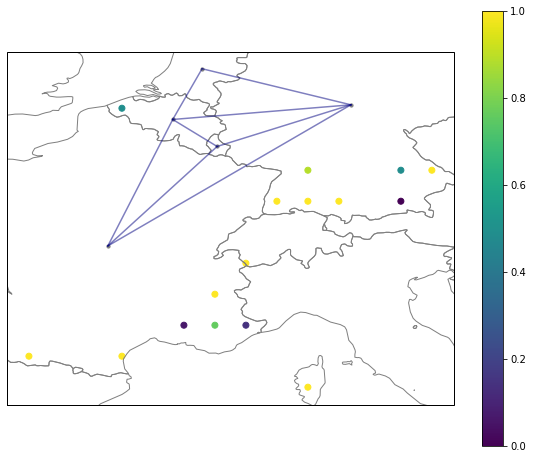

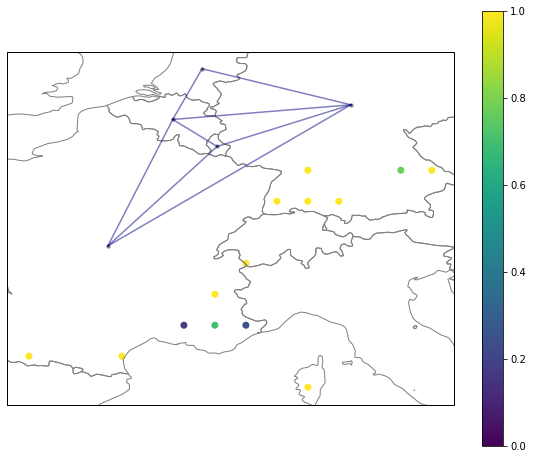

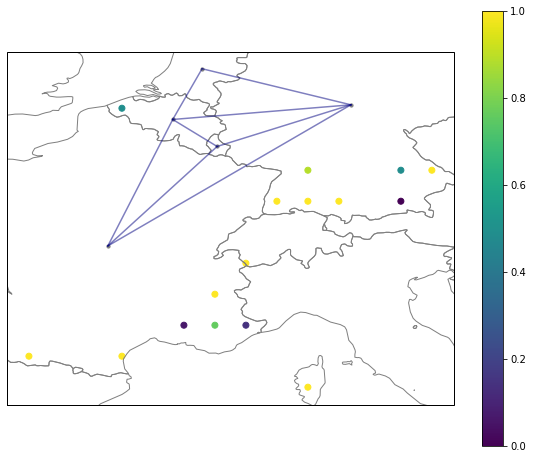

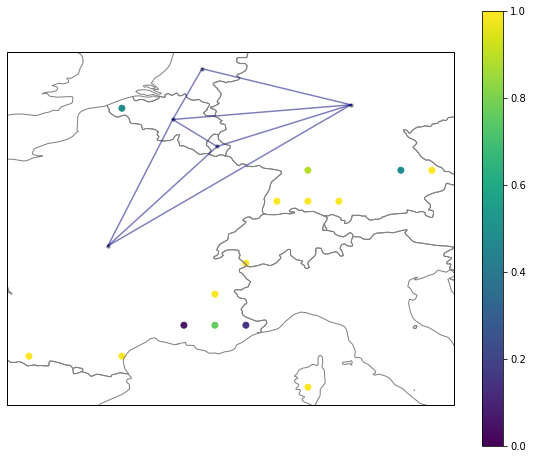

In [57]:
from iepy.topologies.core.plot import plot_topology

min_cap = 1e-3
for case in cases_short:
    net = nets[case]
    ax = plot_topology(net.buses, net.links)
    tech = "pv_residential_national"
    res_generators = net.generators[(net.generators.type == tech) & (net.generators.p_nom_opt >= min_cap)]
    x = res_generators.loc[res_generators.index, "x"].values
    y = res_generators.loc[res_generators.index, "y"].values
    # values = res_generators.p_nom_max.values
    values = (res_generators.p_nom_opt/res_generators.p_nom_max).values
    #values = net.generators_t.p_max_pu[res_generators.index].mean()
    map1 = ax.scatter(x, y, c=values, cmap='viridis', vmin=0, vmax=1.0)
    plt.colorbar(map1, ax=ax)

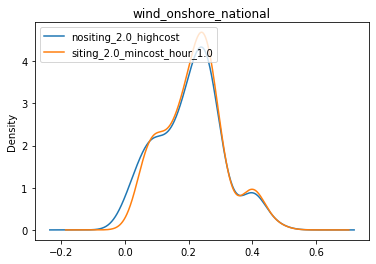

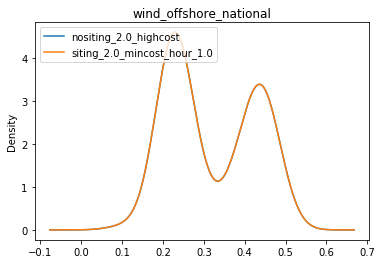

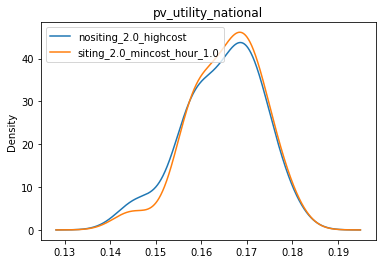

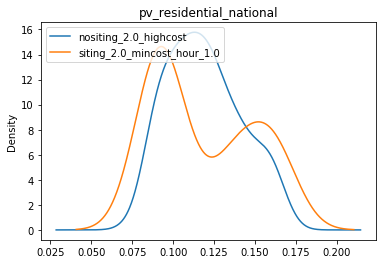

In [28]:
# Res aggregated signal
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
min_cap = 0
cases_tested = cases
for tech in techs:
    plt.figure()
    for case in cases_tested:
        net = nets[case]
        res_gens = net.generators[(net.generators.type == tech) & (net.generators.p_nom_opt >= min_cap)]
        res_gens_p_max_pu = net.generators_t.p_max_pu[res_gens.index]
        res_gens_p_max_pu_agg = res_gens_p_max_pu.mean(axis=0)
        #res_gens_p_max_pu_agg.plot(kind="hist", bins=50, histtype="step")
        res_gens_p_max_pu_agg.plot(kind="kde")

    plt.legend(cases_tested, loc="upper left")
    #plt.ylim([0, 35])
    plt.title(tech)

Yearly RES penetration
84.37
0.8446990137779226
84.19
0.8429033226760988
83.62
0.8383036295558545


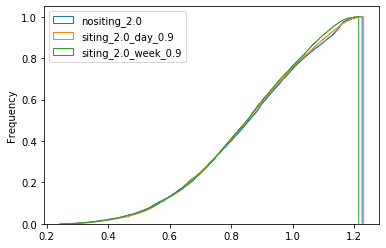

In [120]:
# Res penetration
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
time_agg = net.loads_t.p.index
load_grouped = net.loads_t.p.groupby(time_agg).sum().sum(axis=1)
load = net.loads_t.p.sum().sum()
# print(load)
print("Yearly RES penetration")
for case in cases:
    net = nets[case]
    res_gens = net.generators[net.generators.type.isin(techs)]
    res_gens_p = net.generators_t.p[res_gens.index]
    print(f"{res_gens_p.sum().sum()*100/load:.2f}")
    res_prod_grouped = res_gens_p.groupby(time_agg).sum().sum(axis=1)
    print((res_prod_grouped/load_grouped).mean())
    #(res_prod_grouped/load_grouped).plot(kind="kde")
    (res_prod_grouped/load_grouped).plot(kind="hist", density="True", cumulative="True", histtype='step', bins=1000)
plt.legend(cases, loc="upper left")

In [32]:
# Comparing site in siting runs vs no siting run
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases_short[0]]
nositing_res_gens = nositing_net.generators[nositing_net.generators.type.isin(techs)]
for case in cases_short[1:]:
    net = nets[case]
    res_gens = net.generators[net.generators.type.isin(techs)]
    # Compare p_nom_max
    p_nom_max_diff = nositing_res_gens.loc[res_gens.index, "p_nom_max"] - res_gens["p_nom_max"]
    print("Sites with different p_nom_max: ", p_nom_max_diff[p_nom_max_diff != 0])
    # Compare p_nom_min
    p_nom_min_diff = nositing_res_gens.loc[res_gens.index, "p_nom_min"] - res_gens["p_nom_min"]
    print("Sites with different p_nom_min: ", p_nom_min_diff[p_nom_min_diff != 0])
    p_diff = nositing_net.generators_t.p_max_pu[res_gens.index] - net.generators_t.p_max_pu[res_gens.index]
    locs_with_diff = res_gens.index[(p_diff != 0).sum() != 0]
    print(locs_with_diff)

Sites with different p_nom_max:  Series([], Name: p_nom_max, dtype: float64)
Sites with different p_nom_min:  Series([], Name: p_nom_min, dtype: float64)
Index([], dtype='object', name='name')
Sites with different p_nom_max:  name
Gen wind_onshore_national -4.0-48.0     -0.01215
Gen wind_onshore_national -3.0-48.0     -0.01355
Gen wind_onshore_national -2.0-47.0     -0.00950
Gen wind_onshore_national -2.0-48.0     -0.00885
Gen wind_onshore_national -1.0-43.0     -0.00460
                                          ...   
Gen pv_residential_national 13.0-51.0   -0.07424
Gen pv_residential_national 13.0-54.0    0.32432
Gen pv_residential_national 14.0-51.0   -0.21456
Gen pv_residential_national 14.0-52.0   -0.38816
Gen pv_residential_national 14.0-53.0    0.03728
Name: p_nom_max, Length: 180, dtype: float64
Sites with different p_nom_min:  name
Gen wind_onshore_national 7.0-46.0     NaN
Gen pv_residential_national 7.0-46.0   NaN
Name: p_nom_min, dtype: float64


/home/utilisateur/.local/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



KeyError: "['Gen pv_residential_national 7.0-46.0', 'Gen wind_onshore_national 7.0-46.0'] not in index"

In [26]:
# Comparing site in siting runs vs no siting run -> how much capacity is not covered by siting
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3
nositing_res_gens = nositing_net.generators[(nositing_net.generators.type.isin(techs)) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
nositing_set = set(nositing_res_gens.index)
total_cap = nositing_res_gens.p_nom_opt.sum()
total_gen = (nositing_net.generators_t.p[nositing_res_gens.index]*nositing_res_gens.p_nom_opt).sum().sum()
print(f"Total cap: {total_cap:.3f} GW")
print(f"Total gen: {total_gen/1e3:.3f} TWh")

for case in cases[1:]:
    print()
    print(case)
    net = nets[case]
    res_gens = net.generators[(net.generators.type.isin(techs))]# & (net.generators.p_nom_opt > min_cap)]
    siting_set = set(res_gens.index)
    common_set = nositing_set.intersection(siting_set)
    # Capacity
    common_sites_cap = nositing_res_gens.loc[list(common_set)].p_nom_opt.sum()
    print(f"Common sites cap: {common_sites_cap:.3f} ({common_sites_cap*100/total_cap:.3f}%)")
    # Generation
    common_sites_gen = (nositing_net.generators_t.p[list(common_set)]*nositing_res_gens.loc[list(common_set)].p_nom_opt).sum().sum()
    print(f"Common sites gen: {common_sites_gen/1e3:.3f} ({common_sites_gen*100/total_gen:.3f}%)")
    

Total cap: 1066.153 GW
Total gen: 52399.898 TWh

siting_1.5_day_0.9
Common sites cap: 902.720 (84.671%)
Common sites gen: 41929.909 (80.019%)

siting_1.5_week_0.9
Common sites cap: 805.197 (75.524%)
Common sites gen: 44590.310 (85.096%)


In [84]:
# Per tech
# Comparing site in siting runs vs no siting run -> how much capacity is not covered by siting
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3

percentages_cap = pd.DataFrame(columns=cases[1:], index=techs)
percentages_gen = pd.DataFrame(columns=cases[1:], index=techs)
for tech in techs:
    nositing_res_gens = nositing_net.generators[(nositing_net.generators.type == tech) 
                                                & (nositing_net.generators.p_nom_opt > min_cap)]
    nositing_set = set(nositing_res_gens.index)
    total_cap = nositing_res_gens.p_nom_opt.sum()
    total_gen = (nositing_net.generators_t.p[nositing_res_gens.index]*nositing_res_gens.p_nom_opt).sum().sum()

    for case in cases[1:]:
        net = nets[case]
        res_gens = net.generators[(net.generators.type == tech)]# & (net.generators.p_nom_opt > min_cap)]
        siting_set = set(res_gens.index)
        common_set = nositing_set.intersection(siting_set)
        # Capacity
        common_sites_cap = nositing_res_gens.loc[list(common_set)].p_nom_opt.sum()
        percentages_cap.loc[tech, case] = common_sites_cap*100/total_cap
        # Generation
        common_sites_gen = (nositing_net.generators_t.p[list(common_set)]*nositing_res_gens.loc[list(common_set)].p_nom_opt).sum().sum()
        percentages_gen.loc[tech, case] = common_sites_gen*100/total_gen

print("Capacity")
print(percentages_cap)
print("\nGeneration")
print(percentages_gen)

Capacity
                        siting_day_0.9_highcost siting_week_0.9_highcost
wind_onshore_national                   83.1922                  72.0083
wind_offshore_national                  93.9461                  98.7013
pv_utility_national                     88.1372                  76.1824
pv_residential_national                 79.5581                  34.5752

Generation
                        siting_day_0.9_highcost siting_week_0.9_highcost
wind_onshore_national                   80.6413                  77.4424
wind_offshore_national                  96.6518                  99.6023
pv_utility_national                     88.3367                  65.8239
pv_residential_national                 86.6832                  34.1152


In [78]:
# Are common sites used similarly?
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3
nositing_res_gens = nositing_net.generators[(nositing_net.generators.type.isin(techs)) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
nositing_set = set(nositing_res_gens.index)

for case in cases[1:]:
    print()
    print(case)
    net = nets[case]
    res_gens = net.generators[(net.generators.type.isin(techs))]# & (net.generators.p_nom_opt > min_cap)]
    siting_set = set(res_gens.index)
    common_set = nositing_set.intersection(siting_set)
    # Capacity
    common_sites_cap_1_stage = nositing_res_gens.loc[list(common_set)].p_nom_opt.sum()
    common_sites_cap_2_stage = res_gens.loc[list(common_set)].p_nom_opt.sum()
    print(f"Capacity in common sites (1 vs 2): {common_sites_cap_1_stage:.3f} - {common_sites_cap_2_stage:.3f}")
    # Generation
    common_sites_gen_1_stage = (nositing_net.generators_t.p[list(common_set)]*nositing_res_gens.loc[list(common_set)].p_nom_opt).sum().sum()
    common_sites_gen_2_stage = (net.generators_t.p[list(common_set)]*res_gens.loc[list(common_set)].p_nom_opt).sum().sum()
    print(f"Gen from common sites (1 vs 2): {common_sites_gen_1_stage/1e3:.3f} - {common_sites_gen_2_stage/1e3:.3f}")
    


siting_day_0.9
Capacity in common sites (1 vs 2): 993.778 - 1044.643
Gen from common sites (1 vs 2): 28627.542 - 30874.971

siting_day_0.8
Capacity in common sites (1 vs 2): 926.939 - 977.175
Gen from common sites (1 vs 2): 27482.913 - 29242.074

siting_week_0.8
Capacity in common sites (1 vs 2): 782.845 - 789.588
Gen from common sites (1 vs 2): 24954.540 - 25680.253


In [104]:
# Comparing site per site?
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3
nositing_res_gens = nositing_net.generators[(nositing_net.generators.type.isin(techs)) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
nositing_set = set(nositing_res_gens.index)

percentage_diff = pd.DataFrame(columns=cases[1:], index=["1GW", "1MW", "1kW", "1W"], dtype=float)
for case in cases[1:]:
    print()
    print(case)
    net = nets[case]
    res_gens = net.generators[(net.generators.type.isin(techs))]# & (net.generators.p_nom_opt > min_cap)]
    siting_set = set(res_gens.index)
    common_set = nositing_set.intersection(siting_set)
    # Capacity
    common_sites_cap_1_stage = nositing_res_gens.loc[list(common_set)].p_nom_opt
    common_sites_cap_2_stage = res_gens.loc[list(common_set)].p_nom_opt
    cap_diff = (common_sites_cap_1_stage - common_sites_cap_2_stage) #.abs()
    for v, s in [(1, "1GW"), (1e-3, "1MW"), (1e-6, "1kW"), (1e-9, "1W")]:
        cap_diff_ = cap_diff[cap_diff.abs() > v]
        percentage_diff.loc[s, case] = (1-len(cap_diff_)/len(common_set))*100
        
        #print(f"Diff of capacity: {cap_diff.abs().sum():.3f} out of ({common_sites_cap_1_stage.sum():.3f})")
        #print(f"Number of sites with diff capacity: {len(cap_diff_)} (out of {len(common_set)} common sites)")
        """
        plt.figure()
        cap_diff.plot(kind="hist", histtype="step", cumulative=True, bins=len(cap_diff), density=True)
        plt.xlabel("Capacity difference (1 stage - 2 stage) (GW)")
        plt.title(case)
        """
        # Generation
        #common_sites_gen_1_stage = (nositing_net.generators_t.p[list(common_set)]*nositing_res_gens.loc[list(common_set)].p_nom_opt)
        #common_sites_gen_2_stage = (net.generators_t.p[list(common_set)]*res_gens.loc[list(common_set)].p_nom_opt)
        #gen_diff = (common_sites_gen_1_stage - common_sites_gen_2_stage).abs().sum()
        #print(f"Diff of generation: {gen_diff.sum()/1e3:.3f} (out of {common_sites_gen_1_stage.sum().sum()/1e3:.3f})")
        # print(f"Number of sites with diff generation: {(gen_diff > 1).sum()}")    
        
print(f"Percentage of points with capacity difference below:\n{percentage_diff.round(2)}")


siting_1.0_day_0.9

siting_1.0_week_0.9
Percentage of points with capacity difference below:
     siting_1.0_day_0.9  siting_1.0_week_0.9
1GW               97.71                99.49
1MW               97.18                99.49
1kW               97.00                99.32
1W                96.83                99.15


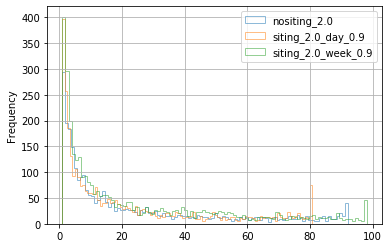

In [44]:
# CCGT usage
for case in cases:
    net = nets[case]
    ccgt_gens = net.generators[net.generators.type == "ccgt"]
    ccgt_p = net.generators_t.p[ccgt_gens.index]
    ccgt_p_sum = ccgt_p.sum(axis=1)
    ccgt_p_sum_pos = ccgt_p_sum[ccgt_p_sum >= 1]
    ccgt_p_sum_pos.plot(kind="hist", bins=100, alpha=0.5, histtype="step")
    # ccgt_p_sum_pos.plot(kind="kde", alpha=0.8)
plt.legend(cases)
plt.grid()

In [43]:
# Storage
techs = ["Li-ion", "phs"]
cycles = pd.DataFrame(columns=cases, index=techs)
for case in cases:
    net = nets[case]
    for tech in techs:
        sus = net.storage_units[net.storage_units.type == tech]
        capacity = (sus.p_nom_opt * sus.max_hours).sum()
        su_ps = net.storage_units_t.p[sus.index]
        intake = -su_ps.where(su_ps < 0, 0).sum().sum()
        cycles.loc[tech, case] = intake/capacity
print(cycles)

       nositing_2.0 siting_2.0_day_0.9 siting_2.0_week_0.9
Li-ion       475.46            371.934             390.362
phs         55.8522            52.6221             49.7098


----------------
Run siting_1.0_day_0.9
126 one-stage wind_onshore_national sites with no match in siting
88 siting wind_offshore_national sites with no match in one-stage
All pv_utility_national sites picked in siting stage are also in the one-stage set. 11 sites less in the siting stage.
86 siting pv_residential_national sites with no match in one-stage


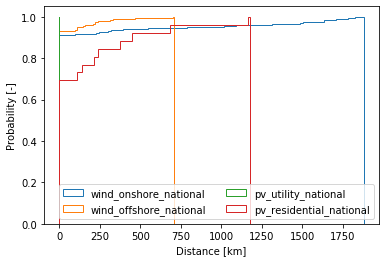

----------------
Run siting_1.0_week_0.9
All wind_onshore_national sites picked in siting stage are also in the one-stage set. 133 sites less in the siting stage.
61 siting wind_offshore_national sites with no match in one-stage
All pv_utility_national sites picked in siting stage are also in the one-stage set. 14 sites less in the siting stage.
14 siting pv_residential_national sites with no match in one-stage


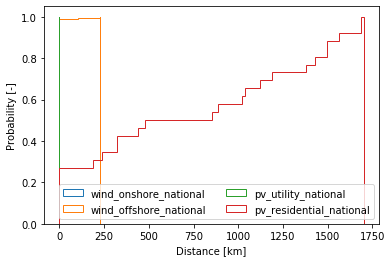

In [103]:
import itertools
from geopy import distance
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3

for case in cases[1:]:
    print('----------------')    
    print(f'Run {case}')
    net = nets[case]
    min_distances = {k: [] for k in techs}
    for tech in techs:
        
        nositing_res_gens = nositing_net.generators[(nositing_net.generators.type == tech)
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
        nositing_set = set(nositing_res_gens.index)
    
        res_gens = net.generators[net.generators.type == tech]# & (net.generators.p_nom_opt > min_cap)]
        siting_set = set(res_gens.index)
        intersection = nositing_set.intersection(siting_set)
        min_distances[tech].extend(list(itertools.repeat(0, len(intersection))))
        sites_excl_one = nositing_set.difference(siting_set)
        sites_excl_two = siting_set.difference(nositing_set)
        all_pairs = list(itertools.product(sites_excl_one, sites_excl_two))
        if not len(all_pairs) and len(sites_excl_one):
            print(f'All {tech} sites picked in siting stage are also in the one-stage set. {len(sites_excl_one)} sites less in the siting stage.')
        elif not len(all_pairs) and len(sites_excl_two):
            print(f'All {tech} sites picked in one stage were picked in the siting stage. {len(sites_excl_two)} sites less in the one-stage.')
        elif len(all_pairs):
            df_pairs = pd.DataFrame(columns=['site1', 'site2', 'dist'], index=np.arange(len(all_pairs)))
            for i, t in enumerate(all_pairs):
                df_pairs.loc[i, 'site1'] = tuple(nositing_res_gens.loc[t[0], ["x", "y"]])
                df_pairs.loc[i, 'site2'] = tuple(res_gens.loc[t[1], ["x", "y"]])
                df_pairs.loc[i, 'dist'] = distance.distance(df_pairs.loc[i, 'site1'], df_pairs.loc[i, 'site2']).km
            while df_pairs.shape[0] > 0:
                df_mindist = df_pairs[df_pairs.dist == df_pairs.dist.min()].iloc[0]
                min_distances[tech].append(df_mindist.dist)
                site1_out = df_mindist['site1']
                site2_out = df_mindist['site2']
                df_pairs = df_pairs[(df_pairs.site1 != site1_out) & (df_pairs.site2 != site2_out)]
            if len(sites_excl_one) > len(sites_excl_two):
                print(f'{len(sites_excl_one)-len(sites_excl_two)} one-stage {tech} sites with no match in siting')
            else:
                print(f'{len(sites_excl_two)-len(sites_excl_one)} siting {tech} sites with no match in one-stage')
        hist, bins, _ = plt.hist(min_distances[tech], bins=100, density=True, cumulative=True, histtype='step', label=tech)
    #plt.title(str(time.split('_')[-1]))
    plt.legend(ncol=2, loc='lower right')
    plt.xlabel('Distance [km]')
    plt.ylabel('Probability [-]')
    plt.show()